In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, join, Column
import re
from tqdm.notebook import tqdm
from scikitplot.metrics import plot_confusion_matrix
from ipywidgets import interact, interact_manual
from ipywidgets.widgets import IntSlider
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
target = Table.read('/home/aalvarez/Work/Data/StarsSEDs/Target.fits')
input_catalog = Table.read('/home/aalvarez/Work/Data/StarsSEDs/TargetWithPhoto.fits')

input_catalog = join(target, input_catalog, 'ID')

uniform = Table.read('/home/aalvarez/Work/Data/StarsSEDs/UniformEBV.fits')
chi2 = Table.read('/home/aalvarez/Work/Data/StarsSEDs/CombinedEBV.fits')
reference = Table.read('/home/aalvarez/Work/Data/StarsSEDs/RefPhotometry.fits', hdu=1)
reference_sed = Table.read('/home/aalvarez/Work/Data/StarsSEDs/Reference.fits')

uniform = join(uniform, input_catalog, 'ID')
chi2 = join(chi2, input_catalog, 'ID')
reference = join(reference, reference_sed, 'ID')

In [3]:
nnpz_config = dict()
with open('/home/aalvarez/Work/Data/StarsSEDs/nnpz.conf') as nnpz_fd:
    exec(nnpz_fd.read(), nnpz_config)

In [4]:
ref_col = nnpz_config['reference_sample_phot_filters']
ref_pairs = list(zip(ref_col[:-1], ref_col[1:]))
flux_col = [flux for flux, error in nnpz_config['target_catalog_filters']]
flux_pairs = list(zip(flux_col[:-1], flux_col[1:]))
flux_pairs, ref_pairs

([('TU_FNU_U_LSST_obs', 'TU_FNU_G_LSST_obs'),
  ('TU_FNU_G_LSST_obs', 'TU_FNU_R_LSST_obs'),
  ('TU_FNU_R_LSST_obs', 'TU_FNU_I_LSST_obs'),
  ('TU_FNU_I_LSST_obs', 'TU_FNU_Z_LSST_obs'),
  ('TU_FNU_Z_LSST_obs', 'TU_FNU_VIS_obs'),
  ('TU_FNU_VIS_obs', 'TU_FNU_Y_NISP_obs'),
  ('TU_FNU_Y_NISP_obs', 'TU_FNU_J_NISP_obs'),
  ('TU_FNU_J_NISP_obs', 'TU_FNU_H_NISP_obs')],
 [('lsst/u', 'lsst/g'),
  ('lsst/g', 'lsst/r'),
  ('lsst/r', 'lsst/i'),
  ('lsst/i', 'lsst/z'),
  ('lsst/z', 'euclid/VIS'),
  ('euclid/VIS', 'euclid/Y'),
  ('euclid/Y', 'euclid/J'),
  ('euclid/J', 'euclid/H')])

In [5]:
mask = np.logical_and(uniform['FLAGS_1'] != 0, chi2['FLAGS_1'] != 0)
uniform = uniform[mask]
chi2 = chi2[mask]
len(chi2)

4376

In [9]:
@interact_manual(i=IntSlider(min=0, max=len(chi2)), continuous_update=False)
def plot_neighbors(i):
    uni_n_ids = uniform['NEIGHBOR_IDS'][i]
    uni_n_scaling = uniform['NEIGHBOR_SCALING'][i]
    chi2_n_ids = chi2['NEIGHBOR_IDS'][i]

    ncols = 2
    nrows = len(flux_pairs) // ncols

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20))

    for pair, ref, ax in zip(flux_pairs, ref_pairs, axes.ravel()):   
        uni_neighbors = reference[np.in1d(reference['ID'], uni_n_ids)]
        chi2_neighbors = reference[np.in1d(reference['ID'], chi2_n_ids)]

        # Uniform
        originx, originy = uni_neighbors[ref[0]], uni_neighbors[ref[1]]
        targetx, targety = uni_neighbors[ref[0]] * uni_n_scaling, uni_neighbors[ref[1]] * uni_n_scaling
        dx, dy = targetx - originx, targety - originy
        ax.quiver(originx, originy, dx, dy, angles='xy', width=0.003, alpha=0.5, zorder=-1)
        ax.scatter(originx, originy, marker='1', label='Uniform')
        ax.scatter(targetx, targety, marker='2', label='Uniform scaled')

        # Chi2
        #ax.scatter(chi2_neighbors[ref[0]], chi2_neighbors[ref[1]], marker='3', label='$\chi^2$')

        ax.scatter(chi2[pair[0]][i], chi2[pair[1]][i], marker='X', label='Target')
        ax.set_xlabel(pair[0])
        ax.set_ylabel(pair[1])
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='i', max=4376), Button(description='Run Interact', style=…

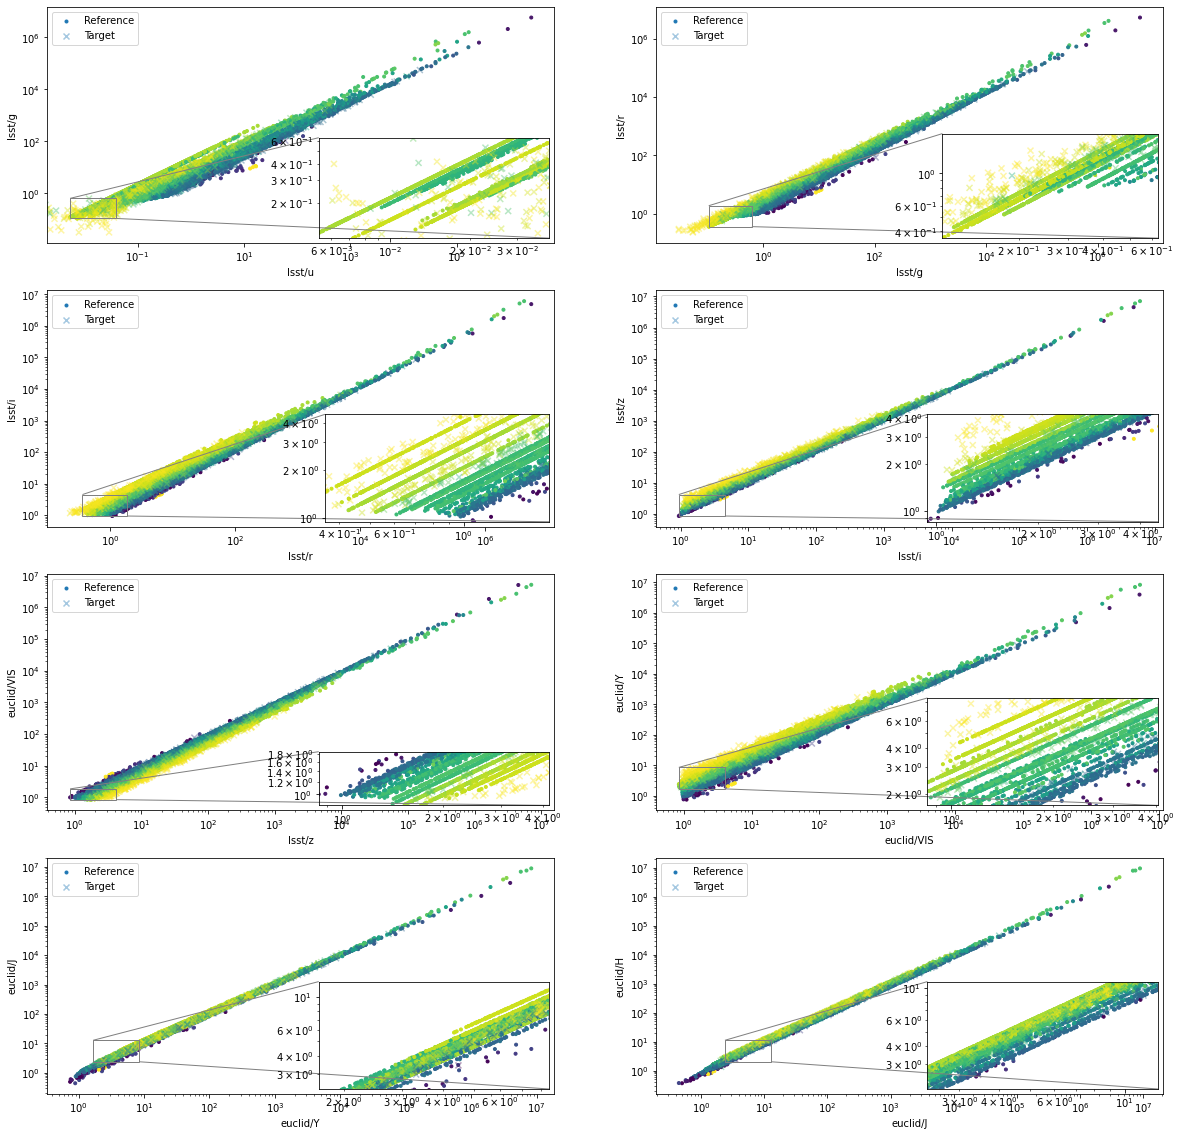

In [10]:
ncols = 2
nrows = len(flux_pairs) // ncols

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 20))

sample = np.arange(len(reference))
np.random.shuffle(sample)
sample = reference[sample[:10000]]
target_sample = np.arange(len(uniform))
np.random.shuffle(target_sample)
target_sample = uniform[target_sample[:1000]]

for pair, ref, ax in zip(flux_pairs, ref_pairs, axes.ravel()):
    refx = sample[ref[0]]
    refy = sample[ref[1]]
    refc = sample['SED-Index']
    targetx = target_sample[pair[0]]
    targety = target_sample[pair[1]]
    targetc = target_sample['SED-Index']
    ax.scatter(refx, refy, c=refc, marker='.', label='Reference')
    ax.scatter(targetx, targety, c=targetc, marker='x', label='Target', alpha=0.4)
    
    # Zoom
    counts, xedges, yedges = np.histogram2d(np.log10(refx), np.log10(refy), bins=20)
    imax = np.argmax(counts)
    xmax, ymax = imax // 20, imax % 20
    limx = 10**xedges[max(0, xmax-1)], 10**xedges[xmax+1]
    limy = 10**yedges[max(0, ymax-1)], 10**yedges[ymax+1]
    axins = zoomed_inset_axes(ax, 5, loc=4)
    axins.scatter(refx, refy, c=refc, marker='.')
    axins.scatter(targetx, targety, c=targetc, marker='x', alpha=0.4)
    axins.set_xlim(*limx)
    axins.set_ylim(*limy)
    axins.set_xscale('log')
    axins.set_yscale('log')
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(ref[0])
    ax.set_ylabel(ref[1])
    ax.legend()